# 整体思路

## Data Processing：
### dataset:  PNAS_workerdataframe_v4.pkl
- there are 25980 individuals in the data set.
- there are still 18250 individuals after removing whose 'log_realized_wage' or 'log_requested_wage' are nan，
- Removing skills that appear less than 3 times in the data set, 1644 skills left
- for each indiviaul, the up-limit #skills they hold is 10


In [196]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg 
import scipy
import pandas as pd
import copy
from collections import Counter
import seaborn as sns

In [193]:
wd1= pd.read_pickle('./PNAS_workerdataframe_v4.pkl')
wd=wd1.dropna(subset=['log_realized_wage','log_requested_wage'])
rqw,rlw=wd['log_requested_wage'],wd['log_realized_wage']

/home/liujing/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(32.125,0.5,'log_realized_wage')

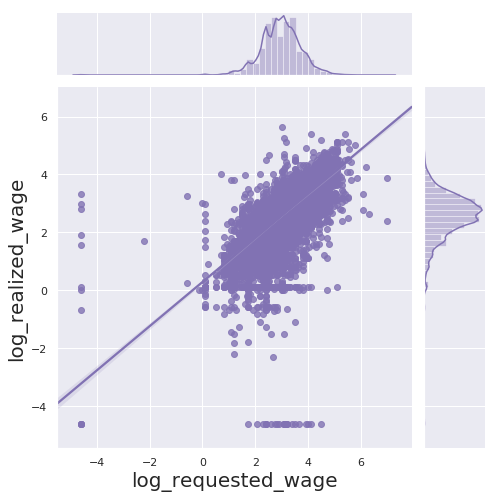

In [194]:
sns.set(style="darkgrid")
tips = sns.load_dataset("tips")
g = sns.jointplot("log_requested_wage", "log_realized_wage", data=wd, kind="reg",color="m", height=7)
plt.xlabel("log_requested_wage",fontsize=20)
plt.ylabel("log_realized_wage",fontsize=20)

In [200]:
#skills-one-hot-codeing
mylst = []
for skills in wd['skills']:
    mylst += skills
NumD = dict(Counter(mylst))
limit_num=2
Remove = [sk for sk in NumD if NumD[sk]<limit_num]# remove skills that appear less than 3 times
Remain = [sk for sk in NumD if NumD[sk]>=limit_num]
print("#Total",len(NumD))
print("#Remove",len(Remove))
print("#Remain",len(Remain))
skills_new=[[sk for sk in tmp if sk not in Remove] for tmp in wd['skills']]

#Total 2116
#Remove 281
#Remain 1835


In [201]:
cut_50=rlw.quantile(.5)
cut_25=rlw.quantile(.25)
cut_75=rlw.quantile(.75)
print(cut_25,cut_50,cut_75)

2.1849270495258133 2.6390573296152584 3.0562455404944515


In [202]:
MAX_LENGTH = max([len(sks) for sks in skills_new])
hidden_size = 24
print("MAX_LENGTH:",MAX_LENGTH)
print("embedding size:",hidden_size)

MAX_LENGTH: 10
embedding size: 24


In [203]:
#制造数据集

with open("./data/names/skill.txt",'w')as f:
    f.write("\n".join(Remain))
with open("./data/names/performance2.txt",'w')as f:
    f.write("\n".join([str(i) for i in range(2)]))
with open("./data/names/performance4.txt",'w')as f:
    f.write("\n".join([str(i) for i in range(4)]))
    
    
with open("./data/skill-performance2.txt",'w')as f:
    for sks,w in zip(skills_new,rlw):
        ww="1" if w>cut_50 else "0"
        f.write(" ".join(sks)+"\t"+ww+"\n")
        
with open("./data/skill-performance4.txt",'w')as f:
    for sks,w in zip(skills_new,rlw):
        if w>cut_75:
            ww="3"
        elif w>cut_50:
            ww='2'
        elif w>cut_25:
            ww='1'
        else:
            ww='0'
        f.write(" ".join(sks)+"\t"+ww+"\n")

In [191]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_forcing_ratio = 0.5

In [160]:
MAX_LENGTH = 10
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS",}
        self.n_words = 1  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs





# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
# class DecoderRNN(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(DecoderRNN, self).__init__()
#         self.hidden_size = hidden_size

#         self.embedding = nn.Embedding(output_size, hidden_size)
#         #self.gru = nn.GRU(hidden_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         output = self.embedding(input).view(1, 1, -1)
#         output = F.relu(output)
#         #output, hidden = self.gru(output, hidden)
#         #output = self.softmax(self.out(output[0]))
#         output = self.softmax(self.out(output[0]))
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(1):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            decoded_words=output_lang.index2word[topi.item()]

        return decoded_words, decoder_attentions[:di + 1]

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
#     encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
#     decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    #criterion = nn.CrossEntropyLoss()
    #criterion = nn.SmoothL1Loss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        #Los.append(loss)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [146]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('skill', 'performance4', False)
print(random.choice(pairs))

Reading lines...
Read 18250 sentence pairs
Trimmed to 11805 sentence pairs
Counting words...
Counted words:
skill 1714
performance4 5
['cms-development css3 html5 jquery laravel-framework mysql php wordpress', '1']


In [147]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.12).to(device)

0m 1s (- 1m 51s) (100 1%) 1.5195
0m 1s (- 1m 24s) (200 2%) 1.4598
0m 2s (- 1m 15s) (300 3%) 1.3936
0m 2s (- 1m 8s) (400 4%) 1.3832
0m 3s (- 1m 6s) (500 5%) 1.3658
0m 4s (- 1m 3s) (600 6%) 1.4016
0m 4s (- 1m 1s) (700 7%) 1.3840
0m 5s (- 1m 0s) (800 8%) 1.3663
0m 5s (- 0m 58s) (900 9%) 1.3851
0m 6s (- 0m 57s) (1000 10%) 1.3962
0m 7s (- 0m 56s) (1100 11%) 1.3737
0m 7s (- 0m 55s) (1200 12%) 1.3548
0m 8s (- 0m 54s) (1300 13%) 1.3611
0m 8s (- 0m 54s) (1400 14%) 1.3646
0m 9s (- 0m 53s) (1500 15%) 1.3222
0m 10s (- 0m 52s) (1600 16%) 1.3256
0m 10s (- 0m 51s) (1700 17%) 1.3806
0m 11s (- 0m 51s) (1800 18%) 1.2848
0m 11s (- 0m 50s) (1900 19%) 1.3097
0m 12s (- 0m 49s) (2000 20%) 1.4014
0m 13s (- 0m 49s) (2100 21%) 1.2582
0m 13s (- 0m 48s) (2200 22%) 1.2769
0m 14s (- 0m 47s) (2300 23%) 1.3406
0m 14s (- 0m 47s) (2400 24%) 1.3060
0m 15s (- 0m 46s) (2500 25%) 1.3388
0m 16s (- 0m 45s) (2600 26%) 1.3273
0m 16s (- 0m 45s) (2700 27%) 1.2920
0m 17s (- 0m 44s) (2800 28%) 1.3301
0m 17s (- 0m 43s) (2900 28%) 1

<Figure size 432x288 with 0 Axes>

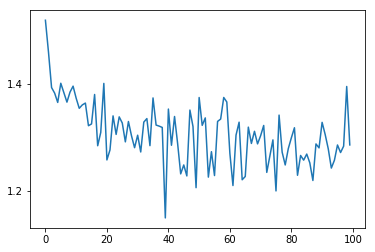

In [149]:
trainIters(encoder1, attn_decoder1, 10000, print_every=100,learning_rate=0.01)

In [98]:
evaluateAll(encoder1, attn_decoder1)

acc 40.262600592969086


In [155]:
input_lang, output_lang, pairs = prepareData('skill', 'performance2', False)
print(random.choice(pairs))
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

Reading lines...
Read 18250 sentence pairs
Trimmed to 11805 sentence pairs
Counting words...
Counted words:
skill 1714
performance2 3
['copywriting creative-writing german proofreading technical-writing transcription translation', '0']


0m 1s (- 1m 45s) (100 1%) 1.0534
0m 1s (- 1m 21s) (200 2%) 0.9951
0m 2s (- 1m 13s) (300 3%) 0.9530
0m 2s (- 1m 8s) (400 4%) 0.8926
0m 3s (- 1m 5s) (500 5%) 0.8246
0m 4s (- 1m 4s) (600 6%) 0.8580
0m 4s (- 1m 2s) (700 7%) 0.8064
0m 5s (- 1m 1s) (800 8%) 0.7935
0m 5s (- 0m 59s) (900 9%) 0.7751
0m 6s (- 0m 58s) (1000 10%) 0.7779
0m 7s (- 0m 58s) (1100 11%) 0.7234
0m 7s (- 0m 57s) (1200 12%) 0.7629
0m 8s (- 0m 56s) (1300 13%) 0.7384
0m 9s (- 0m 55s) (1400 14%) 0.7298
0m 9s (- 0m 54s) (1500 15%) 0.7133
0m 10s (- 0m 53s) (1600 16%) 0.7243
0m 10s (- 0m 53s) (1700 17%) 0.7308
0m 11s (- 0m 52s) (1800 18%) 0.7185
0m 12s (- 0m 51s) (1900 19%) 0.7268
0m 12s (- 0m 50s) (2000 20%) 0.7209
0m 13s (- 0m 49s) (2100 21%) 0.6909
0m 13s (- 0m 49s) (2200 22%) 0.6755
0m 14s (- 0m 48s) (2300 23%) 0.6572
0m 15s (- 0m 47s) (2400 24%) 0.7166
0m 15s (- 0m 46s) (2500 25%) 0.6903
0m 16s (- 0m 46s) (2600 26%) 0.6950
0m 16s (- 0m 45s) (2700 27%) 0.7038
0m 17s (- 0m 44s) (2800 28%) 0.6938
0m 18s (- 0m 44s) (2900 28%) 0

<Figure size 432x288 with 0 Axes>

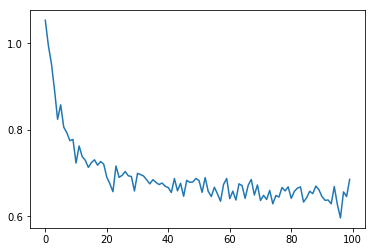

In [156]:
trainIters(encoder1, attn_decoder1, 10000, print_every=100,learning_rate=0.001)

0m 1s (- 1m 51s) (100 1%) 0.6635
0m 1s (- 1m 24s) (200 2%) 0.6350
0m 2s (- 1m 15s) (300 3%) 0.6762
0m 2s (- 1m 10s) (400 4%) 0.6378
0m 3s (- 1m 7s) (500 5%) 0.6382
0m 4s (- 1m 5s) (600 6%) 0.6184
0m 4s (- 1m 3s) (700 7%) 0.6197
0m 5s (- 1m 1s) (800 8%) 0.6142
0m 5s (- 1m 0s) (900 9%) 0.6497
0m 6s (- 0m 59s) (1000 10%) 0.6327
0m 7s (- 0m 58s) (1100 11%) 0.6301
0m 7s (- 0m 57s) (1200 12%) 0.6696
0m 8s (- 0m 56s) (1300 13%) 0.6318
0m 8s (- 0m 55s) (1400 14%) 0.6547
0m 9s (- 0m 54s) (1500 15%) 0.6376
0m 10s (- 0m 53s) (1600 16%) 0.6271
0m 10s (- 0m 52s) (1700 17%) 0.6553
0m 11s (- 0m 52s) (1800 18%) 0.6751
0m 12s (- 0m 51s) (1900 19%) 0.6434
0m 12s (- 0m 50s) (2000 20%) 0.6270
0m 13s (- 0m 49s) (2100 21%) 0.6450
0m 13s (- 0m 49s) (2200 22%) 0.6242
0m 14s (- 0m 48s) (2300 23%) 0.5845
0m 15s (- 0m 47s) (2400 24%) 0.6314
0m 15s (- 0m 46s) (2500 25%) 0.6520
0m 16s (- 0m 46s) (2600 26%) 0.6327
0m 16s (- 0m 45s) (2700 27%) 0.6004
0m 17s (- 0m 45s) (2800 28%) 0.6605
0m 18s (- 0m 44s) (2900 28%) 0

<Figure size 432x288 with 0 Axes>

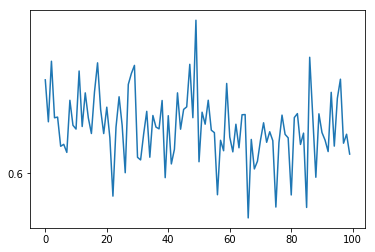

In [172]:
trainIters(encoder1, attn_decoder1, 10000, print_every=100,learning_rate=0.00001)

In [173]:
def evaluateAll(encoder, decoder, n=20000,show=False):
    pp=0
    pairs1=pairs[:n]
    n=len(pairs1)
    for pair in pairs1:
        #print('>', pair[0])
        #print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        #output_sentence = ' '.join(output_words)
        #print('<', output_sentence)
        if  output_words==pair[1]:
            pp+=1
        if show:
            print('>', pair[0])
            print('=', pair[1]) 
            print('<', output_words)
    print("auc",pp/n*100)
evaluateAll(encoder1, attn_decoder1,n=20000)

acc 63.2867429055485


# 在没有加任何先验知识的情况下 利用transformer 模型做出的判断：

输入是技能的组合，设置最大长度为10，

隐层设置为128

以四分位数为基准，做四分类问题，准确率为40.26%

以中位数为基准，做二分类问题，准确率为63%


In [167]:
pred=[]
y=[]
for pair in pairs:
    output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
    pred.append(output_words)
    y.append(pair[1])

In [190]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

accuracy = accuracy_score (y, pred)
print("ACC = ",accuracy)

from sklearn.metrics import classification_report
y_true = [int(i) for i in y]
y_pred = [int(i) for i in pred]
target_names = ['Low', 'High']
print(classification_report(y_true, y_pred, target_names=target_names))

ACC =  0.6335451080050826
             precision    recall  f1-score   support

        Low       0.64      0.75      0.69      6534
       High       0.61      0.49      0.54      5271

avg / total       0.63      0.63      0.63     11805



In [33]:
import matplotlib.pyplot as plt
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     n=len([''] + input_sentence.split(' ') + ['<EOS>'])
#     cax = ax.matshow(attentions.numpy()[0][:n], cmap='bone')
    n=len([''] + input_sentence.split(' ') + ['<EOS>'])-2
    cax = ax.matshow(attentions.numpy()[:1][:,:n], cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + [output_words])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', output_words)
    showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("au69686 au81092 t7420 t7145 t7110")

# evaluateAndShowAttention("au69686 au32005 au182604 au211382 t7110 t0365 t7460 t0545")

# evaluateAndShowAttention("au69686 au211382 t7110 t7460 t0545")

#evaluateAndShowAttention("je ne crains pas de mourir .")

#evaluateAndShowAttention("c est un jeune directeur plein de talent .")